## Color patch pattern analysis - Image processing
    
- form circle shaped segments and position the segments in an array
- circle decetion (shape detection)
- classify and filter by segment size and color
- patch segment color area ratio 
- identify a character (digit) that is formed by the array of UV sensitive material de-colouration segments

### Example of a patch shape and form and segment distribution.


### 3.1 Color masks

- calculate area of a specified colour 

### 3.2 Shape masks 

- calculate area of specific shape 




In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

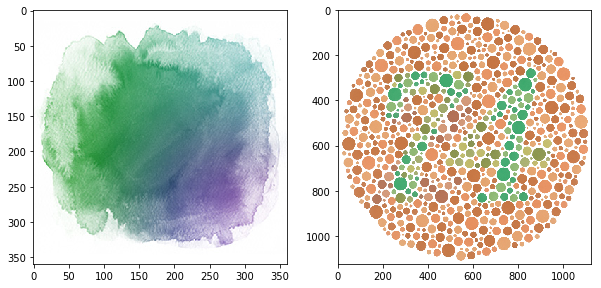

In [314]:
image_1 = cv2.imread('./color_gradient_openCV/mix_2.jpg')
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2 = cv2.imread('./color_gradient_openCV/color-blind-test.jpg')
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 2, figsize=(10,10)); ax[0].imshow(image_1); ax[1].imshow(image_2);

## 3.1 Shape masks 

In [303]:
def circle_detection(image, minR=5, maxR=30):
    """
    image : RGB color image
    """
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img_blur = cv2.medianBlur(gray_img, 5)
    circles = cv2.HoughCircles(img_blur, 
                               cv2.HOUGH_GRADIENT, 1,
                               image.shape[0]/63,
                               param1=200,
                               param2=10,
                               minRadius=minR,
                               maxRadius=maxR)
    #list of circle_radii
#    circ_radii = []
#    if circles is not None:
#        circles = np.uint16(np.around(circles))
#        for i in circles[0,:]:
#            circ_radii.append(i[0],i[1],i[2])
    return circles

def plot_circle_detection(image, minR, maxR):
    image_c = np.copy(image)
    circles = circle_detection(image_c, minR, maxR)    
    # highlight the detected circle with a ring circle of color hc
    hc = (0,255,0)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
            cv2.circle(image_c, (i[0],i[1]), i[2], hc, 2)
    plt.imshow(image_c)

def rgb2hex(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [315]:
# Parameter to tune
minR, maxR = 5, 30

# selecting patches of some radius 
circs = circle_detection(image_2,minR,maxR)
print("Number of cicles with radius {} and {} := {}".format(minR, maxR,len(circs[0,:])))

Number of cicles with radius 5 and 30 := 718


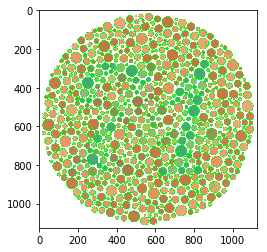

In [316]:
plot_circle_detection(image_2,minR,maxR)

In [82]:
# create the mask image

mask = np.zeros(shape = image_2.shape, dtype='uint8')
means=[]
# iterate through the extracted circles 
for l in circs[0]:
    # ... getting the coordinates of each dot...
    x = int(l[0])
    y = int(l[1])
    r = int(l[2])
    # ... and drawing a white circle on the mask
    c=cv2.circle(img = mask, 
        center = (x, y), 
        radius = r, 
        color = (255, 255, 255), 
        thickness = -1)
    
    # specify a region of interest around the circle 
    # and get the mean value of the colour of that region in RGB
    roi = image_2[y-r:y+r+1, x-r:x+r+1]
    means.append(cv2.mean(roi))
    
# apply the mask for plotting and highlighting the bubble patches area
maskedImage = cv2.bitwise_and(src1 = image_2, src2 = mask)


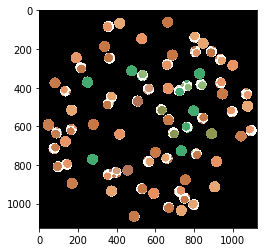

In [86]:
plt.imshow(maskedImage)

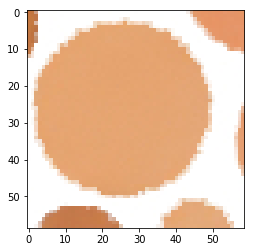

In [302]:
plt.imshow(roi)

In [85]:
# TEST the roi and it's color
# at the center point 
roi[30,30,:] # the colour of the pixel in RGB

array([229, 165, 117], dtype=uint8)

In [209]:
rgb2hex(means[0][:3])

'#d2926a'

### Filter and select the circles by size and colour 

In [317]:
# rounding up the values 
circs = np.uint16(np.around(circs, decimals=2))

In [318]:
# radii for all the selected circles 
circ_radii = circs[:,:,2]
# x,y position of the circles
pos_x, pos_y = circs[:,:,0], circs[:,:,1]

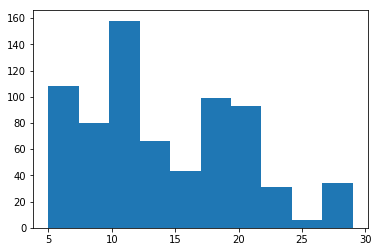

In [319]:
# distribution of circle radii
plt.hist(circ_radii[0]);

In [320]:
u,c = np.unique(np.array(circ_radii),return_counts=True)
value_counts = dict(zip(u,c))
uc = np.asarray((c,u))

In [256]:
# The obtained mean values for the bubble color 
means;

## 3.2 Colour masks

Color area ratio

In [305]:
def create_mask_for_patch(image, r_l, g_l, b_l, r_u, g_u, b_u, sensitivity=35):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    #sensitivity = 35 #30 #25
    
    lower_hsv = np.array([r_l - sensitivity, g_l, b_l])
    upper_hsv = np.array([r_u + sensitivity, g_u, b_u])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_patch(image,r_l, g_l, b_l, r_u, g_u, b_u):
    mask = create_mask_for_patch(image, r_l, g_l, b_l, r_u, g_u, b_u)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

def find_contours(mask_image):
    return cv2.findContours(mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

def calculate_largest_contour_area(contours):
    if len(contours) == 0:
        return 0
    c = max(contours, key=cv2.contourArea)
    return cv2.contourArea(c)

def calculate_contours_area(contours, min_contour_area = 250):
    area = 0
    for c in contours:
        c_area = cv2.contourArea(c)
        if c_area >= min_contour_area:
            area += c_area
    return area

#alpha = 0.5
def show_color_area(image_1,r_l, g_l, b_l, r_u, g_u, b_u):
    image_mask = create_mask_for_patch(image_1,r_l, g_l, b_l, r_u, g_u, b_u)
    image_segmented = segment_patch(image_1, r_l, g_l, b_l, r_u, g_u, b_u)
    overlay = sharpen_image(image_segmented)

    added_image = cv2.addWeighted(image_1,0.3,overlay,0.7,0.0)
    contours = find_contours(image_mask)
    
    area = calculate_contours_area(contours)
    
    cv2.putText( added_image, 
            "Area {} pixels".format(area), 
            (10, 30), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            1, 
            (255, 255, 255),
            3)

    # plt.imshow(added_image)
    return area, added_image

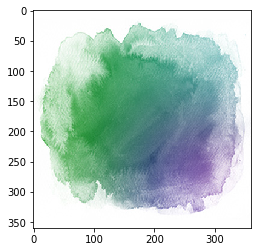

In [306]:
plt.imshow(image_1);

In [307]:
# Purple-ish
#r_l, g_l, b_l, r_u, g_u, b_u = 129, 79, 140, 129, 255, 255
#r_l, g_l, b_l, r_u, g_u, b_u = 128, 20, 123, 234, 75, 255
#r_l, g_l, b_l, r_u, g_u, b_u = 170, 40, 220, 234, 75, 255 #good
r_l, g_l, b_l, r_u, g_u, b_u = 105, 40, 120, 234, 75, 255
A1 = show_color_area(image_1,r_l, g_l, b_l, r_u, g_u, b_u)
#plt.imshow(A1[1])

# Green-ish
r_l, g_l, b_l, r_u, g_u, b_u = 60, 100, 55, 60, 255, 255
A2 = show_color_area(image_1,r_l, g_l, b_l, r_u, g_u, b_u)
#plt.imshow(A2[1])

Colour Area ratio is 1:5.0


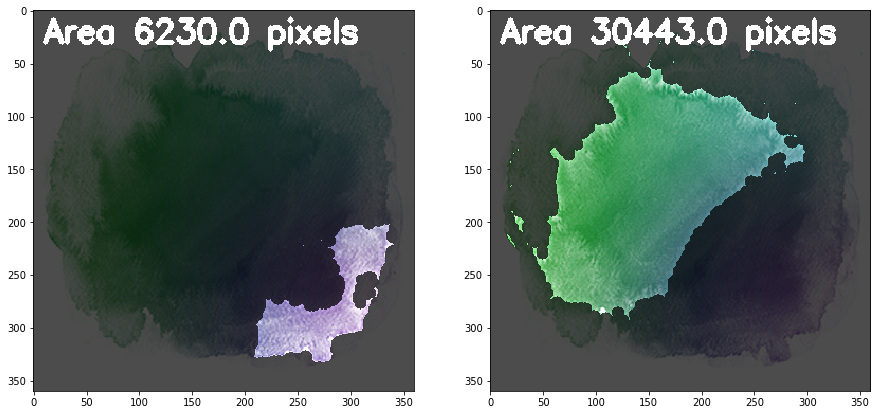

In [308]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(A1[1])
ax[1].imshow(A2[1])
print("Colour Area ratio is 1:{}".format(1/np.around(A1[0]/A2[0], decimals=2)))